In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import sklearn as sk
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import os

In [38]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    # TODO: Implement Function
    return x

In [39]:
def ImportData(folder):
    file_list = []
    file_list.append(pd.read_table('meshcoord.txt',sep="\s+"))
    file_list.append(pd.read_table(folder+'/pressure.txt'))
    file_list.append(pd.read_csv(folder+'/velocity.txt',sep="\s+"))
    df = pd.DataFrame()
    df = pd.concat(file_list,axis=1)
    df = df.drop(['vz','v','ccz'],axis=1)
    
    vx,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(225,200))
    vy,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vy,bins=(225,200))
    p,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.pressure,bins=(225,200))
    _,ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df.vx,bins=(224,199))


    o = np.zeros((225,200))
    xg, yg = np.meshgrid(np.arange(100,125,1),np.arange(0,50,1))
    for i in np.arange(100,125,1):
        for j in np.arange(0,50,1):
            o[i,j] = 1


    VY = np.vstack((np.zeros(200),vy,np.zeros(200)))
    VY = np.hstack((np.zeros((227,1)),VY,np.zeros((227,1))))
    VX = np.vstack((np.zeros(200),vx,np.zeros(200)))
    VX = np.hstack((np.zeros((227,1)),VX,np.zeros((227,1))))
    P = np.vstack((np.zeros(200),p,np.zeros(200)))
    P = np.hstack((np.zeros((227,1)),P,np.zeros((227,1))))
    O = np.vstack((np.ones(200)+5,o,np.ones(200)+2))
    O = np.hstack((np.ones((227,1)),O,np.ones((227,1))))

    VX = VX.T[::-1]
    VY = VY.T[::-1]
    P  = P.T[::-1]
    O  = O.T[::-1]
    
    plist = []
    for i in np.arange(1,201,1):
        for j in np.arange(1,226,1):
            plist.append({'pin':P[i,j],'pright':P[i,j-1],'pleft':P[i,j+1],
                           'pup':P[i-1,j],'pdown':P[i+1,j],
                          'vxin':VX[i,j],'vright':VX[i,j-1],'vleft':VX[i,j+1],
                          'vup':VY[i-1,j],'vdown':VY[i+1,j],'vyin':VY[i,j],
                          'oin':O[i,j],'oright':O[i,j-1],'oleft':O[i,j+1],
                          'oup':O[i-1,j],'odown':O[i+1,j],
                          'ccx':ccx[j-1],'ccy':ccy[-i]
                         })
            
    data= pd.DataFrame(plist)
    return data


In [40]:
folder = os.getcwd()+'/0.11'
data = ImportData(folder)

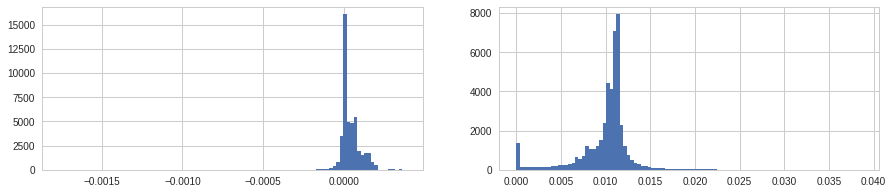

In [42]:
plt.figure(figsize=(15,3))
plt.subplot(121)
data.pin.hist(bins=100)
plt.subplot(122)
data.vxin.hist(bins=100)